In [1]:
import json
import requests
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random
import glob
import zipfile
import os
import shutil

In [2]:
class OtpMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    TRANSIT = 'TRANSIT,WALK'
    BUS = 'BUS,WALK'
    RAIL = 'TRAM,RAIL,SUBWAY,FUNICULAR,GONDOLA,WALK'
    BICYCLE = 'BICYCLE'
    BICYCLE_TRANSIT = 'TRANSIT,BICYCLE'
    PARK_RIDE = 'CAR_PARK,WALK,TRANSIT'
    KISS_RIDE = 'CAR,WALK,TRANSIT'
    BIKE_RIDE = 'BICYCLE_PARK,WALK,TRANSIT'
    RENTED_BICYCLE = 'WALK,BICYCLE_RENT'
    TRANSIT_RENTED_BICYCLE = 'TRANSIT,WALK,BICYCLE_RENT'
    DRT = 'DRT'
    DRT_TRANSIT = 'DRT_TRANSIT'

    _DICT = ['CAR', 'WALK', 'TRANSIT', 'BUS', 'RAIL', 'BICYCLE', 'BICYCLE_TRANSIT', 'PARK_RIDE', 'KISS_RIDE',
             'BIKE_RIDE', 'RENTED_BICYCLE', 'TRANSIT_RENTED_BICYCLE', 'DRT', 'DRT_TRANSIT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'TRANSIT', 'WALK']

    _DRT_MODES = ['DRT', 'DRT_TRANSIT']

    _PT_MODES = ['TRANSIT', 'BUS', 'RAIL']

    @staticmethod
    def get_all_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._DICT]

    @staticmethod
    def get_main_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in OtpMode._DICT

    @staticmethod
    def get_pt_modes():
        return OtpMode._PT_MODES

    @staticmethod
    def get_drt_modes():
        return OtpMode._DRT_MODES

    @staticmethod
    def get_mode(string):
        if OtpMode.contains(string):
            return OtpMode.__getattribute__(OtpMode(), string)
        else:
            raise Exception('unsupported mode {}'.format(string))


In [3]:
class Coord(object):
    """Coordinate.

    Parameters
    ----------
    lat : <float> latitude
    lon : <float> longitude
    latlon : <list> list with both lat and long. Latitude first!
    """
    def __init__(self, lat=None, lon=None, latlon=None):
        if latlon is not None:
            if len(latlon) != 2:
                raise Exception("Wrong coordinate latlon format. Should be a list of two floats.")
            self.lat = latlon[0]
            self.lon = latlon[1]
        elif lat is None or lon is None:
            raise Exception("Coordinates not provided")
        else:
            self.lat = lat
            self.lon = lon

    def to_json(self):
        return json.dumps(self, default=lambda o: self._try(o), sort_keys=True, indent=4, separators=(',', ':'))

    @staticmethod
    def _try(o):
        try:
            if o.__class__ == Coord:
                raise Exception()
            return o.__dict__
        except:
            return str(o)
        
    def __str__(self):
        return str(self.lat) + ',' + str(self.lon)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return self.lat == other.lat and self.lon == other.lon

    def __hash__(self):
        return hash((self.lat, self.lon))


In [4]:
class Leg(object):
    """Leg of a trip. For example, "walk - bus - walk" trip has three legs.
    Used to store trip legs from OTP.

    Parameters
    ----------
    mode : <str> mode of transport
    start_coord : <coord> coordinate of an origin
    end_coord : <coord> coordinate of a destination
    distance : <int> meters
    duration : <int> seconds
    steps : <list> of utils.Step
    """

    # TODO:assignment of mode   as a string is confusing, remove it, or use constant
    def __init__(self, mode=None, start_coord=None, from_stop=None, end_coord=None, to_stop=None,
                 start_time=None, end_time=None,
                 distance=None, duration=None, steps=None):
        self.mode = mode
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration
        self.steps = steps
        # The two below only used for PT legs
        self.from_stop = from_stop
        self.to_stop = to_stop

        self.start_time = start_time
        self.end_time = end_time

    def deepcopy(self):
        if self.steps is None:
            steps = []
        else:
            steps = [step.deepcopy() for step in self.steps if step is not None]
        return Leg(mode=copy.copy(self.mode),
                   start_coord=copy.copy(self.start_coord),
                   from_stop=copy.copy(self.from_stop),
                   end_coord=copy.copy(self.end_coord),
                   to_stop=copy.copy(self.to_stop),
                   start_time=copy.copy(self.start_time),
                   end_time=copy.copy(self.end_time),
                   distance=copy.copy(self.distance),
                   duration=copy.copy(self.duration),
                   steps=steps)


In [5]:
class Trip(object):
    """A list of legs and a total trip duration
    """
    legs = ...  # type: List[Leg]

    def __init__(self):
        self.legs = []
        self.duration = None
        self.distance = None
        self.main_mode = None

    def set_empty_trip(self, mode, coord_start, coord_end):
        """Sets a dummy trip between two coordinates with zero distance, duration and one empty leg"""
        self.set_duration(0)
        self.set_distance(0)
        self.main_mode = mode
        self.legs = [Leg(mode=mode, start_coord=coord_start, end_coord=coord_end, distance=0, duration=0,
                         steps=[Step(coord_start, coord_end, 0, 0)])]

    def dumps(self):
        return self.__dict__

    def get_leg_modes(self):
        """Returns a list of modes from the legs"""
        return [l.mode for l in self.legs]

    def deepcopy(self):
        nt = Trip()
        nt.duration = copy.copy(self.duration)
        nt.distance = copy.copy(self.distance)
        nt.main_mode = copy.copy(self.main_mode)
        nt.legs = [leg.deepcopy() for leg in self.legs]
        return nt

    def main_mode_from_legs(self):
        leg_modes = self.get_leg_modes()

        if LegMode.CAR in leg_modes:
            return OtpMode.CAR
        elif LegMode.BUS in leg_modes or LegMode.SUBWAY in leg_modes or \
                LegMode.TRAM in leg_modes or LegMode.RAIL in leg_modes:
            return OtpMode.TRANSIT
        elif LegMode.BICYCLE in leg_modes:
            return OtpMode.BICYCLE
        elif LegMode.WALK in leg_modes:
            return OtpMode.BICYCLE
        else:
            log.error('Main mode unrecognized. Returning None. Kick the developer to make a proper function.')
            return None

    def set_duration(self, dur):
        self.duration = dur

    def set_main_mode(self, mode):
        self.main_mode = mode
    
    def set_distance(self, dist):
        self.distance = dist
    
    def append_leg(self, leg):
        self.legs.append(leg)
        
    def __str__(self):
        return '{} trip, takes {} distance {}'\
            .format(self.main_mode, self.duration, self.distance)

    def __repr__(self):
        return str(self)


In [6]:
class Step(object):
    """Arguments:|
    start_coord       <Coord>|
    distance    <int>|
    duration    <int>|
    """
    def __init__(self, start_coord, end_coord, distance, duration):
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration

    @staticmethod
    def get_empty_step(coord):
        return Step(start_coord=coord, end_coord=coord, distance=0, duration=0)

    def deepcopy(self):
        return Step(start_coord=copy.copy(self.start_coord),
                    end_coord=copy.copy(self.end_coord),
                    distance=copy.copy(self.distance),
                    duration=copy.copy(self.duration),
                    )

    def dumps(self):
        return self.__dict__

    def __str__(self):
        return 'Step distance {:.1f}, duration {:.1f}'.format(self.distance, self.duration)

    def __repr__(self):
        return self.__str__()


In [7]:
def osrm_route_request(from_place, to_place):
    url_coords = '{}{},{};{},{}' \
        .format('http://0.0.0.0:5000/route/v1/driving/',
                from_place.get('lon'), from_place.get('lat'), to_place.get('lon'), to_place.get('lat'))
    url_full = url_coords + '?annotations=true&geometries=geojson&steps=true'
    resp = requests.get(url=url_full)
    return _parse_osrm_response(resp)


def _parse_osrm_response(resp):
    # if resp.status_code != requests.codes.ok:
    #     resp.raise_for_status()

    jresp = resp.json()
    # if jresp.get('code') != 'Ok':
    #     log.error(jresp.get('code'))
    #     log.error(jresp.get('message'))
    #     resp.raise_for_status()

    trip = Trip()
    trip.legs = [Leg()]
    trip.legs[0].steps = []

    legs = jresp.get('routes')[0].get('legs')
    for leg in legs:
        steps = leg.get('steps')
        for step in steps:
            new_step = Step(distance=step.get('distance'),
                            duration=step.get('duration'),
                            start_coord=Coord(lon=step.get('geometry').get('coordinates')[0][0],
                                              lat=step.get('geometry').get('coordinates')[0][1]),
                            end_coord=Coord(lon=step.get('geometry').get('coordinates')[-1][0],
                                            lat=step.get('geometry').get('coordinates')[-1][1]))
            # OSRM makes circles on roundabouts. And makes empty step in the end. Exclude these cases from a route
            if new_step.start_coord != new_step.end_coord:
                trip.legs[0].steps.append(new_step)
        if len(trip.legs[0].steps) == 0:
            waypoints = jresp.get('waypoints')
            trip.legs[0].steps.append(Step(distance=0,
                                           duration=0,
                                           start_coord=Coord(lon=waypoints[0].get('location')[0],
                                                             lat=waypoints[0].get('location')[1]),
                                           end_coord=Coord(lon=waypoints[1].get('location')[0],
                                                           lat=waypoints[1].get('location')[1])
                                           )
                                      )
    trip.legs[0].start_coord = trip.legs[0].steps[0].start_coord
    trip.legs[0].end_coord = trip.legs[0].steps[-1].end_coord
    trip.legs[0].duration = sum([step.duration for step in trip.legs[0].steps])
    trip.legs[0].distance = sum([step.distance for step in trip.legs[0].steps])
    trip.legs[0].mode = OtpMode.DRT

    trip.distance = trip.legs[0].distance
    trip.duration = trip.legs[0].duration
    trip.main_mode = OtpMode.CAR
    return trip


In [8]:
scenario_name = "0"
path_to_zip_file = '/home/ai6644/Malmo/Tools/Simulation results/tmp/'+\
                   scenario_name+'/log.zip'

In [9]:
day_sec = int(86400)
day_h = int(24)

In [10]:
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    try:
        shutil.rmtree('data/zip')
    except (FileNotFoundError, OSError) as e:
        pass
    os.mkdir('data/zip')
    zip_ref.extractall('data/zip')
path = 'data/zip/' + os.listdir('data/zip')[0] + '/trip_dump.json'

In [11]:
all_files = glob.glob("data/zip/*/vehicle_logs/vehicle_occupancy_*")
n_cars = len(all_files)

In [12]:
# n_cars = 25

In [13]:
fp = open(path)
tdump = json.load(fp)
fp.close()

In [14]:
persons = tdump.get('person')

In [15]:
persons[52]

{'actual_trips': [{'legs': [{'mode': 'RAIL',
     'start_coord': {'lat': 54.833248871746, 'lon': 11.138192792442},
     'end_coord': {'lat': 54.776641265717, 'lon': 11.501672983677},
     'distance': 24506.90922520159,
     'duration': 1320.0,
     'steps': [],
     'from_stop': 8602623,
     'to_stop': 8602619,
     'trip_id': 65297523,
     'route': '710R',
     'route_id': 246032,
     'start_time': 48120.0,
     'end_time': 49440.0}],
   'duration': 1320.0,
   'distance': 24506.90922520159,
   'main_mode': 'TRANSIT,WALK'}],
 'planned_trips': [{'legs': [{'mode': 'RAIL',
     'start_coord': {'lat': 54.833248871746, 'lon': 11.138192792442},
     'end_coord': {'lat': 54.776641265717, 'lon': 11.501672983677},
     'distance': 24506.90922520159,
     'duration': 1320.0,
     'steps': [],
     'from_stop': 8602623,
     'to_stop': 8602619,
     'trip_id': 65297523,
     'route': '710R',
     'route_id': 246032,
     'start_time': 48120.0,
     'end_time': 49440.0}],
   'duration': 1320.0,

In [16]:
drt_legs = []
drt_transit_legs = []
trip_length = []
drt_persons = []

for person in persons:
    atrips = person.get('actual_trips')
    if atrips == []:
        continue
        
#     if not(22000 < atrips[0]['legs'][0]['start_time'] < 33000):
#         continue
        
#     if not(36000 < atrips[0]['legs'][0]['start_time'] < 50000):
#         continue

#     if not(63000 < atrips[0]['legs'][0]['start_time'] < 83400):
#         continue
        
    if atrips[0]['main_mode'] == 'DRT':
        for trip in atrips:
            alegs = [leg for leg in trip.get('legs') if leg.get('mode') in ['DRT']]
            if len(alegs) == 0:    
                continue
            adur = alegs[0]['duration']

        ptrips = person.get('planned_trips')
        for trip in ptrips:
            plegs = [leg for leg in trip.get('legs') if leg.get('mode') in ['DRT']]
            if len(plegs) == 0:    
                continue
            pdur = plegs[0]['duration']
#             pdur = osrm_route_request(plegs[0].get('start_coord'), plegs[0].get('end_coord')).duration

        if (plegs != [] and alegs != []):        
            drt_legs.append((pdur, adur))
            drt_persons.append(person)
    
    
    atrips = person.get('actual_trips')
    if atrips == []:
        continue
    if atrips[0]['main_mode'] == 'DRT_TRANSIT':
        for trip in atrips:
            alegs = [leg for leg in trip.get('legs') if leg.get('mode') in ['DRT']]
            if len(alegs) == 0:    
                continue
            adur = alegs[0]['duration']

        ptrips = person.get('planned_trips')
        for trip in ptrips:
            plegs = [leg for leg in trip.get('legs') if leg.get('mode') in ['DRT']]
            if len(plegs) == 0:    
                continue
            pdur = plegs[0]['duration']
#             pdur = osrm_route_request(plegs[0].get('start_coord'), plegs[0].get('end_coord')).duration

        if (plegs != [] and alegs != []):
            drt_transit_legs.append((pdur, adur))
          


In [17]:
drt_transit_legs

[(573.0, 573.0),
 (573.0, 573.0),
 (121.5, 121.5),
 (543.4000000000015, 543.4),
 (1053.5, 1053.5),
 (732.5999999999985, 732.5999999999999),
 (328.59999999999854, 329.70000000000005),
 (743.5999999999985, 743.6),
 (249.70000000000073, 249.7),
 (148.5, 148.5),
 (209.39999999999418, 209.4),
 (1842.5, 1842.5),
 (541.6999999999971, 541.7),
 (573.0, 573.0),
 (656.5999999999985, 656.6),
 (562.8000000000029, 622.8),
 (432.29999999999563, 432.3),
 (931.0999999999985, 931.0999999999999),
 (295.8000000000029, 295.8),
 (290.90000000000146, 290.9),
 (1048.5999999999985, 1048.6),
 (630.0, 630.0),
 (695.2000000000007, 697.0),
 (335.5, 335.5),
 (1473.5, 1549.2999999999997),
 (682.8000000000029, 682.8),
 (318.6999999999971, 1873.3),
 (573.0, 573.0),
 (657.1999999999971, 657.1999999999999),
 (499.70000000000437, 559.7),
 (1509.2000000000007, 1655.2),
 (469.1999999999971, 574.5999999999999),
 (368.8000000000029, 368.79999999999995),
 (263.8000000000029, 516.3),
 (1067.699999999997, 1127.7),
 (931.3000000

In [18]:
# drt_diff = [(adur - pdur, (adur - pdur)/pdur) for pdur, adur in drt_legs]
# drt_transit_diff = [(adur - pdur, (adur - pdur)/pdur) for pdur, adur in drt_transit_legs]
drt_diff = [(adur - pdur, adur/pdur) for pdur, adur in drt_legs]
drt_transit_diff = [(adur - pdur, adur/pdur) for pdur, adur in drt_transit_legs]

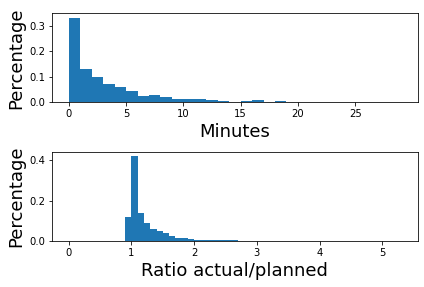

In [50]:
fig = plt.figure()
x = [x[0] for x in drt_diff]
ax = fig.add_subplot(211)
ax.hist(x=x, bins=np.arange(0,max(x),60), weights=np.ones(len(x)) / len(x))
ax.set_xticks([0,300, 600, 900, 1200, 1500])
ax.set_xticklabels([0, 5, 10 , 15, 20, 25])
ax.set_xlabel('Minutes', fontsize=18)
ax.set_ylabel('Percentage', fontsize=18)

x = [x[1] for x in drt_diff]
ax = fig.add_subplot(212)
ax.hist(x=x, bins=np.arange(0,max(x),0.1), weights=np.ones(len(x)) / len(x))
ax.set_xlabel('Ratio actual/planned', fontsize=18)
ax.set_ylabel('Percentage', fontsize=18)

fig.tight_layout()
plt.savefig('data/drt_planned_vs_act.svg', dpi=600)

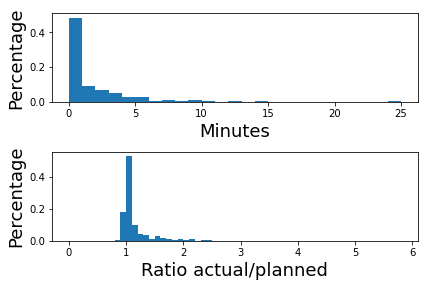

In [49]:
x = [x[0] for x in drt_transit_diff]
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(x=x, bins=np.arange(0,max(x),60), weights=np.ones(len(x)) / len(x))
ax.set_xticks([0,300, 600, 900, 1200, 1500])
ax.set_xticklabels([0, 5, 10 , 15, 20, 25])
ax.set_xlabel('Minutes', fontsize=18)
ax.set_ylabel('Percentage', fontsize=18)

x = [x[1] for x in drt_transit_diff]
ax = fig.add_subplot(212)
ax.hist(x=x, bins=np.arange(0,max(x),0.1), weights=np.ones(len(x)) / len(x))
ax.set_xlabel('Ratio actual/planned', fontsize=18)
ax.set_ylabel('Percentage', fontsize=18)

fig.tight_layout()
plt.savefig('data/drt_transit_planned_vs_act.svg', dpi=600)

In [21]:
len(drt_transit_diff)

237

In [23]:
len(drt_diff)

232

# Looking for people with ratio > 2

In [36]:
[l for l in drt_diff if l[1]> 2 ]

[(502.0, 2.0120967741935485),
 (364.99999999999704, 2.1067313523347297),
 (467.20000000000005, 2.0123510292524376),
 (326.8999999999928, 2.0648208469055143),
 (293.0999999999972, 2.02554233729879),
 (357.8150000000154, 2.154987088444196),
 (340.29999999999995, 2.2645856558900106)]

In [37]:
[leg[0] for leg in drt_legs if leg[1]/leg[0] > 2]

[496.0,
 329.8000000000029,
 461.5,
 307.0,
 285.8000000000029,
 309.8000000000029,
 269.09999999999854]

In [28]:
persons[1]

{'actual_trips': [{'legs': [{'mode': 'CAR',
     'start_coord': {'lat': 55.64069134, 'lon': 13.68783357},
     'end_coord': {'lat': 55.393154616952565, 'lon': 12.914975206078273},
     'distance': 73581.84699999997,
     'duration': 3364.0,
     'steps': [{'start_coord': {'lat': 55.640847884004636,
        'lon': 13.687428567106748},
       'end_coord': None,
       'distance': 290.01800000000003,
       'duration': 29.0},
      {'start_coord': {'lat': 55.6415056, 'lon': 13.6917518},
       'end_coord': None,
       'distance': 136.753,
       'duration': 21.0},
      {'start_coord': {'lat': 55.64271840000001, 'lon': 13.6913914},
       'end_coord': None,
       'distance': 281.477,
       'duration': 26.0},
      {'start_coord': {'lat': 55.642715100000004, 'lon': 13.6869972},
       'end_coord': None,
       'distance': 60.808,
       'duration': 15.0},
      {'start_coord': {'lat': 55.6426923, 'lon': 13.6864199},
       'end_coord': None,
       'distance': 897.4870000000001,
       

In [38]:
for person in persons:
    if person['planned_trips'] == []:
        continue
        
    if person['planned_trips'][0]['duration'] == 496.0:
        p = person

In [39]:
p['actual_trips'][0]['duration']

998.0

In [40]:
p

{'actual_trips': [{'legs': [{'mode': 'DRT',
     'start_coord': {'lat': 55.63135684224555, 'lon': 13.690174631963982},
     'end_coord': {'lat': 55.62854505175056, 'lon': 13.658745277793637},
     'distance': 6835.799999999999,
     'duration': 998.0,
     'steps': [{'start_coord': {'lat': 55.63135684224555,
        'lon': 13.690174631963982},
       'end_coord': {'lat': 55.63135684224555, 'lon': 13.690174631963982},
       'distance': 0,
       'duration': 60},
      {'start_coord': {'lat': 55.6311, 'lon': 13.69005},
       'end_coord': {'lat': 55.630909, 'lon': 13.691282},
       'distance': 80.2,
       'duration': 10.6},
      {'start_coord': {'lat': 55.630909, 'lon': 13.691282},
       'end_coord': {'lat': 55.630555, 'lon': 13.691174},
       'distance': 40,
       'duration': 7.1},
      {'start_coord': {'lat': 55.630555, 'lon': 13.691174},
       'end_coord': {'lat': 55.630935, 'lon': 13.688572},
       'distance': 168.8,
       'duration': 20.9},
      {'start_coord': {'lat': 5

In [41]:
id = 2279295

In [42]:
this guy has twm > 2

SyntaxError: invalid syntax (964653434.py, line 1)